In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import torch
from torch.optim import SGD
from torch import nn

## Access src directory from ./notebooks/ folder
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

from src.Snip import SNIP
from src.models import ConvNet
# from src.optimization import epoch

import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [3]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)


In [4]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [5]:
import time
from src.tools import AverageMeter

def epoch(data, model, criterion, snip_pruning=None,  optimizer=None, PRINT_INTERVAL=100):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):
#         images = images.reshape(-1, sequence_length, input_size).to(device)
#         labels = labels.to(device)
        
#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)

        input = input.reshape(-1, sequence_length, input_size).cuda()
        target = target.cuda()

       # with torch.no_grad():

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            #snip_pruning.prune_parameters()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prediction = output.argmax(1)
        prec = (prediction == target).sum().cpu().item() / target.shape[0]
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_acc.update(prec)
        avg_batch_time.update(batch_time)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:5.1f} ({top1.avg:5.1f})\n'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_acc))
            if optimizer and 'loss_plot' in globals():
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec {top1.avg:5.2f} \n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_acc))

    return avg_acc, avg_loss


In [6]:
def train_model(model, snip = None, epochs = 20):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    model = model.cuda()
    criterion = criterion.cuda()
    
    if snip:
        hooks = snip.register_masks()
        assert snip.K == snip.get_nonzero_param_number()

    train_losses = []
    test_losses = []
    accuracys = []
    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        _, loss = epoch(train_loader, model, criterion,snip_pruning=snip, optimizer=optimizer)
        # Phase d'evaluation
        with torch.no_grad():
            acc_test, loss_test = epoch(test_loader, model, criterion)

        train_losses.append(loss.avg)
        test_losses.append(loss_test.avg)
        accuracys.append(acc_test.avg)

    if snip:
        for hook in hooks:
            hook.remove()
        nonzero_params = snip.get_nonzero_param_number()
        print(nonzero_params)
        assert snip.K == nonzero_params

    return train_losses, test_losses, accuracys

def print_losses_and_acc(training_losses_, test_losses_, acc_):
    plt.title("L'erreur moyenne d'un patch dans generation des noms")
    plt.plot(np.arange(len(training_losses_)), training_losses_, label="Train")
    plt.plot(np.arange(len(test_losses_)), test_losses_, label="Test")
    plt.ylabel("L'erreur")
    plt.xlabel('Epochs')
    plt.legend()
    plt.figure()
    plt.plot(np.arange(len(acc_)), acc_)
    plt.show()

In [7]:
original_model = RNN(input_size, hidden_size, num_layers, num_classes)
train_losses, test_losses, accuracys  = train_model(original_model);

=== EPOCH 1 =====

[TRAIN Batch 000/600]	Time 0.019s (0.019s)	Loss 2.3064 (2.3064)	Prec   0.1 (  0.1)

[TRAIN Batch 100/600]	Time 0.013s (0.012s)	Loss 0.7319 (1.5342)	Prec   0.8 (  0.4)

[TRAIN Batch 200/600]	Time 0.014s (0.012s)	Loss 0.3667 (1.0606)	Prec   0.9 (  0.6)

[TRAIN Batch 300/600]	Time 0.012s (0.012s)	Loss 0.4060 (0.8308)	Prec   0.9 (  0.7)

[TRAIN Batch 400/600]	Time 0.012s (0.012s)	Loss 0.3172 (0.6857)	Prec   0.9 (  0.8)

[TRAIN Batch 500/600]	Time 0.012s (0.012s)	Loss 0.2472 (0.5923)	Prec   0.9 (  0.8)


===============> Total time 7s	Avg loss 0.5240	Avg Prec  0.82 

[EVAL Batch 000/100]	Time 0.008s (0.008s)	Loss 0.1186 (0.1186)	Prec   0.9 (  0.9)


===============> Total time 0s	Avg loss 0.1419	Avg Prec  0.96 

=== EPOCH 2 =====

[TRAIN Batch 000/600]	Time 0.014s (0.014s)	Loss 0.0895 (0.0895)	Prec   1.0 (  1.0)

[TRAIN Batch 100/600]	Time 0.012s (0.012s)	Loss 0.1217 (0.1469)	Prec   1.0 (  1.0)

[TRAIN Batch 200/600]	Time 0.012s (0.012s)	Loss 0.0446 (0.1466)	Prec   1.0 ( 

[TRAIN Batch 500/600]	Time 0.012s (0.012s)	Loss 0.0481 (0.0239)	Prec   1.0 (  1.0)


===============> Total time 7s	Avg loss 0.0236	Avg Prec  0.99 

[EVAL Batch 000/100]	Time 0.008s (0.008s)	Loss 0.0133 (0.0133)	Prec   1.0 (  1.0)


===============> Total time 0s	Avg loss 0.0401	Avg Prec  0.99 

=== EPOCH 12 =====

[TRAIN Batch 000/600]	Time 0.013s (0.013s)	Loss 0.0101 (0.0101)	Prec   1.0 (  1.0)

[TRAIN Batch 100/600]	Time 0.012s (0.012s)	Loss 0.0154 (0.0218)	Prec   1.0 (  1.0)

[TRAIN Batch 200/600]	Time 0.012s (0.012s)	Loss 0.0406 (0.0207)	Prec   1.0 (  1.0)

[TRAIN Batch 300/600]	Time 0.012s (0.012s)	Loss 0.0461 (0.0200)	Prec   1.0 (  1.0)

[TRAIN Batch 400/600]	Time 0.012s (0.012s)	Loss 0.0046 (0.0205)	Prec   1.0 (  1.0)

[TRAIN Batch 500/600]	Time 0.012s (0.012s)	Loss 0.0090 (0.0209)	Prec   1.0 (  1.0)


===============> Total time 7s	Avg loss 0.0203	Avg Prec  0.99 

[EVAL Batch 000/100]	Time 0.008s (0.008s)	Loss 0.0022 (0.0022)	Prec   1.0 (  1.0)


===============> Total time 0s

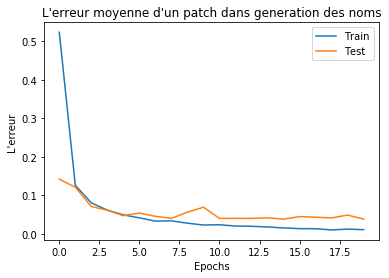

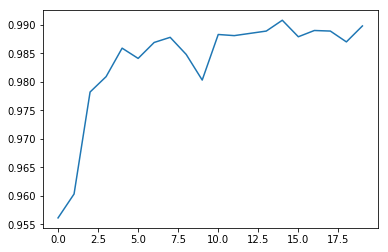

In [8]:
print_losses_and_acc(train_losses, test_losses, accuracys)

In [12]:
prune_model = RNN(input_size, hidden_size, num_layers, num_classes)
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = total_param_number // 10
print("10% of params : {}".format(K))
C_masks = snip.compute_mask(train_loader, K=K)


Original number of params : 214282
10% of params : 21428


RuntimeError: input must have 3 dimensions, got 4